In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from py_ball import playbyplay, boxscore, team
import time
import numpy as np
from sklearn import linear_model
import pickle

In [36]:
headers = {
    'Accept-Encoding': 'gzip, deflate, sdch',
    'Accept-Language': 'en-US,en;q=0.8,ru;q=0.6',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
    'Referer': 'https://stats.nba.com/teams/boxscores-traditional/',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

In [37]:
TOTAL_GAMES_PER_YEAR = 1230

In [38]:
with open('model.pickle', 'rb') as model:
    time_to_model = pickle.load(model)

In [39]:
def get_seconds_left(period, time_string):
    time_in_quarter = 12 #normal quarter is 12 minutes long
    if period > 4:
        time_in_quarter=5 #if it's overtime, 5 mins long
    mins, seconds = time_string.split(':') #from a string like "11:20", we have 11 mins, 20 seconds
    extra_after_quarter = (4-period)*time_in_quarter*60 
    if period > 4:
        #if overtime, we go into negatives, so 10 seconds into overtime is -10 and so on
        extra_after_quarter = (5-period)*time_in_quarter*60 
        time_elapsed = (time_in_quarter*60) - ((int(mins)*60)+(int(seconds))) # convert to seconds
        return extra_after_quarter-time_elapsed
    else:
        return extra_after_quarter+(int(mins)*60)+(int(seconds)) #convert to seconds

In [40]:
"""
Here, we are getting data in the same format as we do with the train set (check out that notebook for in depth comments)
The code is essentially the same, with some minor tweaks.
"""
def get_test(game_id):
    test_x = []
    test_y = []
    times = []
    diff = []
    pbp = playbyplay.PlayByPlay(headers=headers, game_id=game_id).data
    bxscore = boxscore.BoxScore(headers=headers, game_id=game_id, endpoint='boxscoresummaryv2').data
    team_abr = []
    game_summary = (bxscore['GameSummary'])[0]
    home_team_id = game_summary['HOME_TEAM_ID']
    visitor_team_id = game_summary['VISITOR_TEAM_ID']
    
    home_team_data = team.Team(headers=headers, endpoint='teaminfocommon', team_id=home_team_id).data
    visitor_team_data = team.Team(headers=headers, endpoint='teaminfocommon', team_id=visitor_team_id).data
    
    home = home_team_data['TeamInfoCommon'][0]['TEAM_ABBREVIATION']
    away = visitor_team_data['TeamInfoCommon'][0]['TEAM_ABBREVIATION']
        
    jump_event = pbp['PlayByPlay'][1]
    home_has_ball = (jump_event['HOMEDESCRIPTION'] != None)
    current_quarter = 1
    current_margin = 0
    home_wins = int(pbp['PlayByPlay'][-1]['SCOREMARGIN']) > 0
    last_second = 2880
    game_x = {}
    game_y = []
    added_this_game = []
    actual_times = []        
            
    for event in pbp['PlayByPlay'][2:]:

        seconds_left_in_game = get_seconds_left(event['PERIOD'], event['PCTIMESTRING'])

        for sec in range(seconds_left_in_game+1, last_second):
            if sec % 3 == 0 and (sec not in added_this_game):
                game_x[sec] = [current_margin, home_wins, home_has_ball]
                game_y.append(int(home_wins))
                added_this_game.append(sec)

        last_second = seconds_left_in_game

        home_desc = (event['HOMEDESCRIPTION'] != None)
        visitor_desc = (event['VISITORDESCRIPTION'] != None)

        if home_desc and not visitor_desc:
            home_has_ball = True

        if visitor_desc and not home_desc:
            home_has_ball = False

        if home_desc and visitor_desc:
            if ('STEAL' in event['HOMEDESCRIPTION']) or ('BLOCK' in event['HOMEDESCRIPTION']):
                home_has_ball = True
            else:
                home_has_ball = False

        if event['SCOREMARGIN'] != None:
            margin = 0
            if event['SCOREMARGIN'] != 'TIE':
                margin = (int(event['SCOREMARGIN']))
                current_margin = margin

        if seconds_left_in_game % 3 == 0 and seconds_left_in_game not in added_this_game:  
            game_x[seconds_left_in_game] = [current_margin, home_wins, home_has_ball]
            game_y.append(int(home_wins))
            added_this_game.append(int(seconds_left_in_game))

        test_x = (game_x)
        times = (list(game_x.keys()))
        diff.append(current_margin)
        actual_times.append(seconds_left_in_game)
        
    return test_x, times, diff, actual_times, home, away
    

In [41]:
def brier_score(won, wp_arr):
    size_of_arr = len(wp_arr)
    cum_brier_score = 0
    for ind_prob in wp_arr:
        cum_brier_score += (won-ind_prob)**2
    return cum_brier_score/size_of_arr

In [45]:
"""
given the game_id we can plot the win probability
"""
def plot_probs_for_test(game_id, model=time_to_model, plot_home=True, plot_away=False):
    print(game_id)
    test_x, times, diff, actual_times, home, away = get_test(game_id)
    times = np.insert(times, 0, 2880)
    probs = []
    for time in times[1:]:
        training_key = time
        if training_key < 0:
            for ot in range(0,10):
                if (ot*5*60)+training_key > 0:
                    training_key = (ot*5*60)+training_key
                    print(training_key)
                    break
        time_prob = model[training_key].predict_proba([[test_x[time][0], test_x[time][2]]])[0]
        probs.append(time_prob)
    
    probs = np.array(probs)
    
    probs_away = np.insert(probs[:,0], 0, 0.5)
    probs_home = np.insert(probs[:,1], 0, 0.5)
    
    end_lim = 2880-(len(probs_home)*3)
    
    if plot_home or plot_away:
        fig, ax = plt.subplots(1,2)
        
        times, probs_home = zip(*sorted(zip(times, probs_home)))
        times, probs_away = zip(*sorted(zip(times, probs_away)))
        
        ax[0].set_title("Point Differential")
        ax[0].plot(actual_times, diff)
        ax[0].set_xlim(2880, end_lim)
        if plot_home:
            ax[1].plot(times, probs_home, label=home)
        else:
            ax[1].plot(times, probs_away, label=away)
        ax[1].set_xlim(2880, end_lim)
        ax[1].set_ylim(0.0, 1.0)
        ax[1].set_title("Win Probability")
        plt.legend(loc='best')
        plt.show()
    
    return probs_home, probs_away, home, away

In [46]:
plt.rcParams["figure.figsize"] = (20,6)

0041800233
279
282
285
288
291
294
297
270
273
276
264
267
261
258
237
240
243
246
249
252
255
231
234
213
216
219
222
225
228
210
207
189
192
195
198
201
204
186
183
174
177
180
171
168
165
153
156
159
162
150
138
141
144
147
114
117
120
123
126
129
132
135
111
90
93
96
99
102
105
108
87
81
84
78
63
66
69
72
75
60
48
51
54
57
42
45
39
18
21
24
27
30
33
36
12
15
9
6
3
300
279
282
285
288
291
294
297
276
264
267
270
273
261
243
246
249
252
255
258
240
237
216
219
222
225
228
231
234
213
210
186
189
192
195
198
201
204
207
183
171
174
177
180
168
153
156
159
162
165
150
129
132
135
138
141
144
147
126
111
114
117
120
123
99
102
105
108
90
93
96
87
75
78
81
84
72
66
69
63
48
51
54
57
60
45
42
36
39
33
30
12
15
18
21
24
27
9
6
3
300
282
285
288
291
294
297
270
273
276
279
267
249
252
255
258
261
264
246
243
240
234
237
231
219
222
225
228
216
204
207
210
213
186
189
192
195
198
201
183
174
177
180
153
156
159
162
165
168
171
135
138
141
144
147
150
132
129
120
123
126
111
114
117
108
87
90

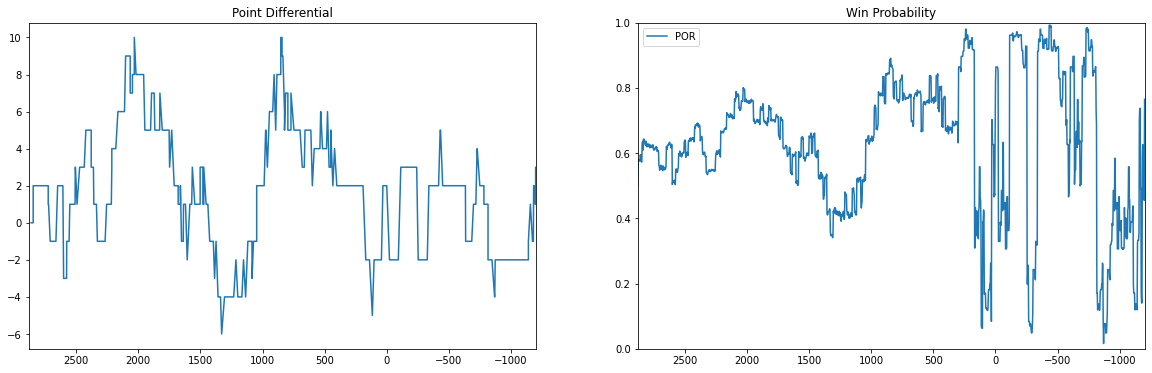

In [48]:
probs_home, probs_away, home, away = plot_probs_for_test("0041800233", plot_home=True)

In [49]:
brier_score(int(probs_home[-1]>0.5), probs_home)

0.43919047404108785